# 必要なモジュルールのインポート

In [1]:
import numpy as np
import math
from __future__ import division
from sklearn.base import BaseEstimator, ClassifierMixin
import matplotlib.pyplot as plt
%matplotlib inline

# 概要説明
作成した連想記憶モデルについて述べる．このモデルのハミルトニアンは
$$
\hat{H} = \sum_{ij} J_{ij}s_i s_j
$$

で与えられる．ここで$J_{ij}$は相互作用係数であり．モデルに記憶させるパターン$\xi^i, i={1, \dots, p}$に対して
$$
J_{ij} = \sum_{i=1}^p \xi^i \xi^i
$$
である.

パターンを学習したモデルに対して，新たなパターン$\mu=(s_1, s_2, \dots, s_m)^T$から記憶したパターンを想起するためには，状態更新則

$$
 s_i^{t+1} = \sum_{j}J_{ij} s_j^{t}
$$

を用いる．

# 課題内容

In [94]:
def put_noise(in_array, percent):
    '''
        in_arrayのpercent%の要素に雑音を導入する（=値を反転させる）
    '''
    in_array = in_array.ravel()
    num_noize = int(len(in_array) * percent)
    if num_noize > 0:
        noise_places = np.arange(0, num_noize, dtype=np.int)
        in_array[noise_places] = in_array[noise_places] * (-1)
    return in_array

# 今回の課題のために実装した連想記憶モデルクラス

In [101]:
class Associatron(BaseEstimator, ClassifierMixin):
    """
        連想記憶モデルクラス：記憶パターン（P×N 行列），結合係数（N×N行列）
        想起パターン数はM個．各タイムステップでのオーバーラップをベクトルで保持する
        なお，ここでは2次元のwidth×height行列の記憶パターン，想起パターンを１次元のベクトルの
        形で保持する．表示する際には２次元に変換して返す．
    """
    def __init__(self):
        pass
        
    def fit(self, patterns):
        '''
            データからの学習を行う．
            実質的に，行っているのは結合係数の計算のみ
            patterns: 行（データ） 列（特徴量）
        '''
        self.patterns = patterns.astype(np.float)
        self.patterns_n = patterns.shape[0]
        self.num_features = patterns.shape[1]
        self.Jij = np.zeros((self.num_features, self.num_features))
        for row in range(self.patterns_n):
            vec = self.patterns[row, :].reshape(1, self.num_features)
            self.Jij += np.dot(vec.T, vec)
        self.Jij /= self.num_features
        return self
    
    def predict(self, X, max_iteration=1000):
        '''
            入力データから推論を行う．後述の_update関数及び_cal_overlap
            関数を順次呼び出し，想起の各タイムステップでのオーバーラップを計算し
            それらを返す関数
        '''
        counter = 0
        overlaps = list()
        while True:
            if counter >= max_iteration:
                break
            else:
                tmp = X
                X = self._update(X)
                overlaps.append(self._cal_overlaps(X))
                counter += 1
        # 実際のprediction部．更新後のXと埋め込まれたパターンを
        # 比較し，最も近い(=overlapが大きい)ものを分類結果として返す
        # 最終的なoverlap -> overlaps[-1]
        return np.argmax(overlaps[-1]), np.array(overlaps)
        
    def _update(self, current_state):
        '''
            predict関数の引数として与えられたデータからの推論を
            行う際の状態更新用関数．
            入力データXからランダムに１つ要素を抽出し，状態更新則
            に従って更新を行い，そのXを返す
        '''
        # ランダムに更新箇所を選ぶ
        update_site = np.random.randint(0, self.num_features)
        st = current_state[update_site]             
        # 状態更新則に則って更新を行う
        non_update_site = np.ones_like(current_state, dtype=bool) * np.True_
        non_update_site[update_site] = np.False_
        current_state[update_site] = math.copysign(
            1, np.sum(self.Jij[update_site, non_update_site] * current_state[non_update_site]))
        return current_state
    
    def _cal_overlaps(self, X):
        '''
            入力行列Xとモデルに設定された正解データそれぞれとのオーバーラップ
            を計算し返す関数．
        '''
        X = X.reshape(1, len(X))
        overlaps = np.dot(X, self.patterns.T)/float(X.shape[1])
        return overlaps.ravel()
        

# 以下，実際のシミュレーション

In [147]:
# 100回の試行を行い，それぞれの結果を記録する
def multiple_simulation_n(noise_ratio, num_trial, num_input, plot=True, num_features=25):
    '''
        上記Associatronクラスを用いたシミュレーションを行う関数．
        5*5の行列を2個用いて学習を行った後，学習に用いた最初の行列に対して5%~50%(5%おき)のノイズを導入した行列を入力として
        それぞれoverlapを評価する．同様のシミュレーションを10回行う．
    '''
    # 入力データはランダムに生成．
    last_overlaps = list()
    right_or_wrong = list()
    for i in range(num_trial):
        tmp_data = np.random.randint(0, 2, num_features).reshape(1, num_features)
        tmp_data[tmp_data == 0] = -1
        data = tmp_data.copy()
        for j in range(num_input-1):
            tmp_data = np.random.randint(0, 2, num_features).reshape(1, num_features)
            tmp_data[tmp_data == 0] = -1
            data = np.concatenate((data,tmp_data), axis=0)
        # データの学習
        associatron = Associatron()
        associatron.fit(data)
        input_data = put_noise(data[0], noise_ratio*0.01)
        predicted_label, overlaps = associatron.predict(input_data, max_iteration=100)
        if plot == True:
            for j in range(num_input):
                plt.plot(overlaps[:, j])
            plt.show()
        last_overlaps.append(overlaps[-1, 0])
        right_or_wrong.append(predicted_label==0)
    return np.mean(np.array(last_overlaps)), np.sum(right_or_wrong)/num_trial

In [118]:
# 画像2種類を用意し，ノイズを5%から50%程度に増加させた場合の想起性能
mean_overlaps = list()
mean_right_answers = list()
for noise_ratio in range(5, 51, 5):
    num_trial, num_input, plot = 100, 2, False
    mean_overlap, mean_right_answer = multiple_simulation_n(
        noise_ratio=noise_ratio, num_trial=num_trial, num_input=num_input, plot=plot)
    mean_overlaps.append(mean_overlap)
    mean_right_answers.append(mean_right_answer)
mean_overlaps = np.array(mean_overlaps)
mean_right_answers = np.array(mean_right_answers)

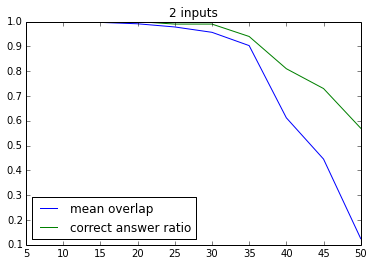

In [125]:
plt.plot(mean_overlaps, label='mean overlap')
plt.plot(mean_right_answers, label='correct answer ratio')
plt.title(str(num_input) + ' inputs')
plt.xticks(range(0, 10), range(5, 51, 5))
plt.legend(loc='best')

In [127]:
# 画像3種類を用意し，ノイズを5%から50%程度に増加させた場合の想起性能
mean_overlaps = list()
mean_right_answers = list()
for noise_ratio in range(5, 51, 5):
    num_trial, num_input, plot = 100, 3, False
    mean_overlap, mean_right_answer = multiple_simulation_n(
        noise_ratio=noise_ratio, num_trial=num_trial, num_input=num_input, plot=plot)
    mean_overlaps.append(mean_overlap)
    mean_right_answers.append(mean_right_answer)
mean_overlaps = np.array(mean_overlaps)
mean_right_answers = np.array(mean_right_answers)

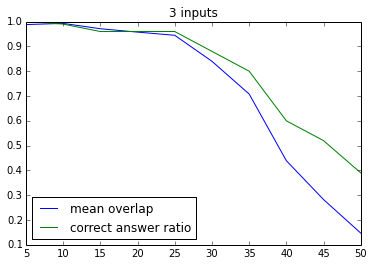

In [128]:
plt.plot(mean_overlaps, label='mean overlap')
plt.plot(mean_right_answers, label='correct answer ratio')
plt.title(str(num_input) + ' inputs')
plt.xticks(range(0, 10), range(5, 51, 5))
plt.legend(loc='best')

In [129]:
# 画像4種類を用意し，ノイズを5%から50%程度に増加させた場合の想起性能
mean_overlaps = list()
mean_right_answers = list()
for noise_ratio in range(5, 51, 5):
    num_trial, num_input, plot = 100, 4, False
    mean_overlap, mean_right_answer = multiple_simulation_n(
        noise_ratio=noise_ratio, num_trial=num_trial, num_input=num_input, plot=plot)
    mean_overlaps.append(mean_overlap)
    mean_right_answers.append(mean_right_answer)
mean_overlaps = np.array(mean_overlaps)
mean_right_answers = np.array(mean_right_answers)

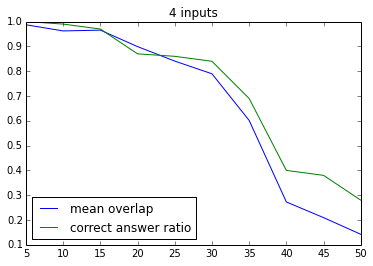

In [130]:
plt.plot(mean_overlaps, label='mean overlap')
plt.plot(mean_right_answers, label='correct answer ratio')
plt.title(str(num_input) + ' inputs')
plt.xticks(range(0, 10), range(5, 51, 5))
plt.legend(loc='best')

In [131]:
# 画像5種類を用意し，ノイズを5%から50%程度に増加させた場合の想起性能
mean_overlaps = list()
mean_right_answers = list()
for noise_ratio in range(5, 51, 5):
    num_trial, num_input, plot = 100, 5, False
    mean_overlap, mean_right_answer = multiple_simulation_n(
        noise_ratio=noise_ratio, num_trial=num_trial, num_input=num_input, plot=plot)
    mean_overlaps.append(mean_overlap)
    mean_right_answers.append(mean_right_answer)
mean_overlaps = np.array(mean_overlaps)
mean_right_answers = np.array(mean_right_answers)

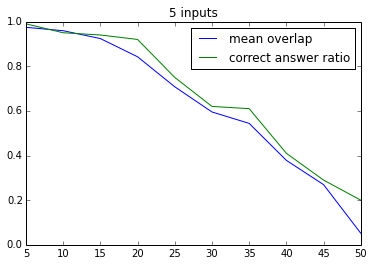

In [132]:
plt.plot(mean_overlaps, label='mean overlap')
plt.plot(mean_right_answers, label='correct answer ratio')
plt.title(str(num_input) + ' inputs')
plt.xticks(range(0, 10), range(5, 51, 5))
plt.legend(loc='best')

In [133]:
# 画像6種類を用意し，ノイズを5%から50%程度に増加させた場合の想起性能
mean_overlaps = list()
mean_right_answers = list()
for noise_ratio in range(5, 51, 5):
    num_trial, num_input, plot = 100, 6, False
    mean_overlap, mean_right_answer = multiple_simulation_n(
        noise_ratio=noise_ratio, num_trial=num_trial, num_input=num_input, plot=plot)
    mean_overlaps.append(mean_overlap)
    mean_right_answers.append(mean_right_answer)
mean_overlaps = np.array(mean_overlaps)
mean_right_answers = np.array(mean_right_answers)

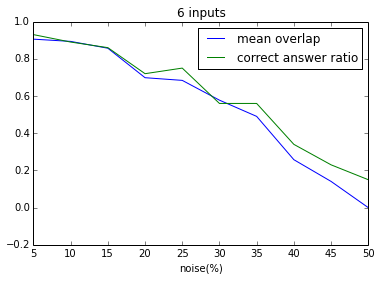

In [138]:
plt.plot(mean_overlaps, label='mean overlap')
plt.xlabel('noise(%)')
plt.plot(mean_right_answers, label='correct answer ratio')
plt.title(str(num_input) + ' inputs')
plt.xticks(range(0, 10), range(5, 51, 5))
plt.legend(loc='best')

## 課題1: 記憶させる画像を2種類から7種類による想起率の推移

2
3
4
5
6
7


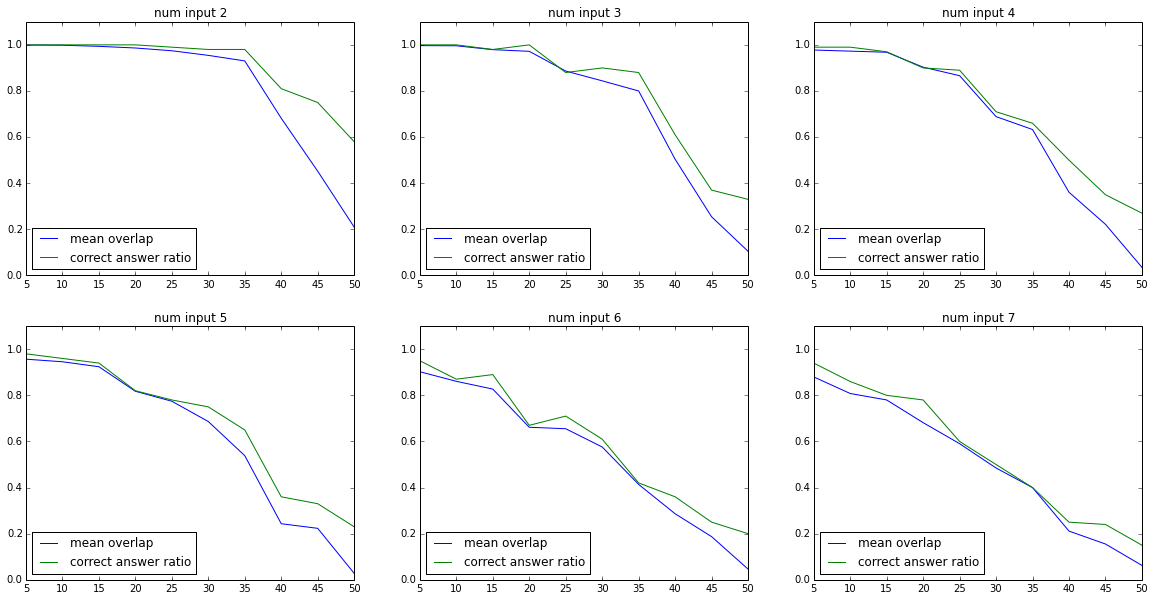

In [154]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
plt.setp(axes, xticks=range(0, 10), xticklabels=range(5, 51, 5))
for num_input, ax in zip(range(2, 8), axes.flatten()):
    print num_input
    # 画像6種類を用意し，ノイズを5%から50%程度に増加させた場合の想起性能
    mean_overlaps = list()
    mean_right_answers = list()
    for noise_ratio in range(5, 51, 5):
        num_trial, plot = 100, False
        mean_overlap, mean_right_answer = multiple_simulation_n(
            noise_ratio=noise_ratio, num_trial=num_trial, num_input=num_input, plot=plot)
        mean_overlaps.append(mean_overlap)
        mean_right_answers.append(mean_right_answer)
    mean_overlaps = np.array(mean_overlaps)
    mean_right_answers = np.array(mean_right_answers)
    # plot部
    ax.set_ylim((0, 1.1))
    ax.set_xticks(range(0, 10), range(5, 51, 5))
    ax.set_title('num input '+str(num_input))
    ax.plot(mean_overlaps, label='mean overlap')
    ax.plot(mean_right_answers, label='correct answer ratio')
    ax.legend(loc='lower left')    

2
3
4
5
6
7


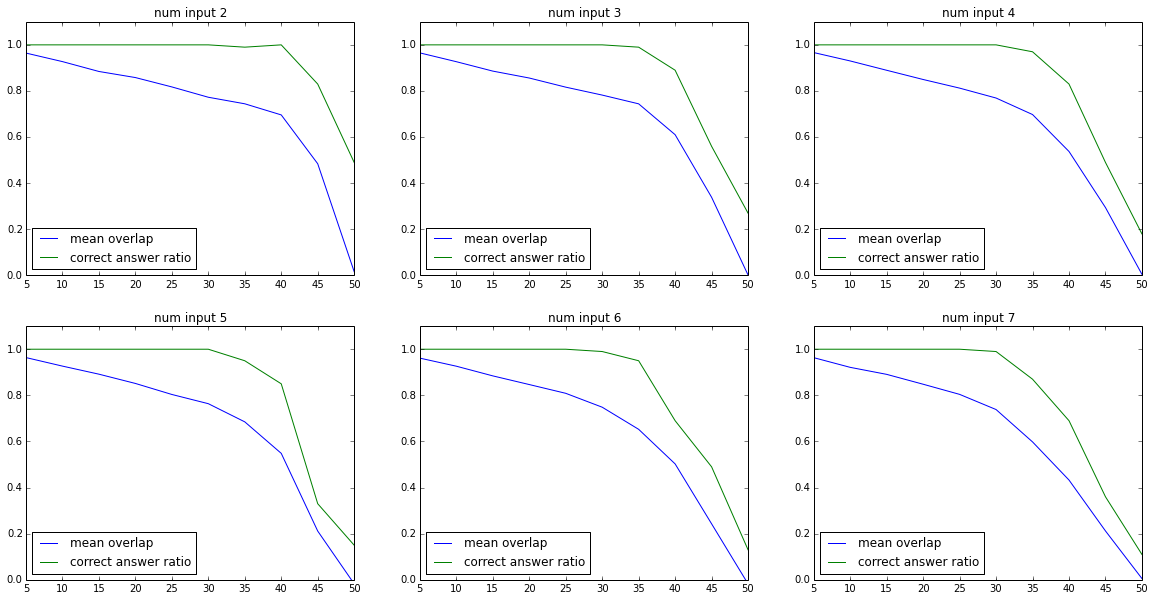

In [155]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
plt.setp(axes, xticks=range(0, 10), xticklabels=range(5, 51, 5))
for num_input, ax in zip(range(2, 8), axes.flatten()):
    print num_input
    # 画像6種類を用意し，ノイズを5%から50%程度に増加させた場合の想起性能
    mean_overlaps = list()
    mean_right_answers = list()
    for noise_ratio in range(5, 51, 5):
        num_trial, plot = 100, False
        mean_overlap, mean_right_answer = multiple_simulation_n(
            noise_ratio=noise_ratio, num_trial=num_trial, num_input=num_input, plot=plot, num_features=100)
        mean_overlaps.append(mean_overlap)
        mean_right_answers.append(mean_right_answer)
    mean_overlaps = np.array(mean_overlaps)
    mean_right_answers = np.array(mean_right_answers)
    # plot部
    ax.set_ylim((0, 1.1))
    ax.set_xticks(range(0, 10), range(5, 51, 5))
    ax.set_title('num input '+str(num_input))
    ax.plot(mean_overlaps, label='mean overlap')
    ax.plot(mean_right_answers, label='correct answer ratio')
    ax.legend(loc='lower left')    

In [ ]:
# 画像6種類を用意し，ノイズを5%から50%程度に増加させた場合の想起性能
mean_overlaps = list()
mean_right_answers = list()
for noise_ratio in range(5, 51, 5):
    num_trial, num_input, num_trialplot = 100, False
    mean_overlap, mean_right_answer = multiple_simulation_n(
        noise_ratio=noise_ratio, num_trial=num_trial, num_input=num_input, plot=plot)
    mean_overlaps.append(mean_overlap)
    mean_right_answers.append(mean_right_answer)
mean_overlaps = np.array(mean_overlaps)
mean_right_answers = np.array(mean_right_answers)
# plot部
ax.set_ylim((0, 1.1))
ax.set_xticks(range(0, 10), range(5, 51, 5))
ax.set_title('num input '+str(num_input))
ax.plot(mean_overlaps, label='mean overlap')
ax.plot(mean_right_answers, label='correct answer ratio')
ax.legend(loc='lower left')    